In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
"""Data Augmentation"""
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Train',
                                           class_mode = 'categorical',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11825 images belonging to 3 classes.


In [4]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=64)

Found 3698 images belonging to 3 classes.
Found 2956 images belonging to 3 classes.


In [5]:
inc = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
)

In [6]:
for layer in inc.layers:           
    layer.trainable = False

In [7]:
x = Flatten()(inc.output)
d1 = Dense(1024, activation= 'relu')(x)

d2 = Dense(1024, activation= 'relu')(d1)

prediction= Dense(units=3 , activation='softmax')(d2)

modelv2 = Model(inc.input,prediction)

In [8]:
modelv2.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:
early = EarlyStopping(monitor='accuracy', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [10]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.7033995966580235, 1: 1.0246079195910234, 2: 0.695915725047081}


C:\Users\amara\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [11]:
hist = modelv2.fit(train, steps_per_epoch= len(train), epochs= 50, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
185/185 [==============================] - 135s 661ms/step - loss: 3.4344 - accuracy: 0.6874 - val_loss: 0.4777 - val_accuracy: 0.8153
Epoch 2/50
185/185 [==============================] - 178s 965ms/step - loss: 0.6118 - accuracy: 0.7654
Epoch 3/50
185/185 [==============================] - 290s 2s/step - loss: 0.5445 - accuracy: 0.7910
Epoch 4/50
185/185 [==============================] - 344s 2s/step - loss: 0.5267 - accuracy: 0.7949
Epoch 5/50
185/185 [==============================] - 348s 2s/step - loss: 0.4971 - accuracy: 0.8113
Epoch 6/50
185/185 [==============================] - 262s 1s/step - loss: 0.4614 - accuracy: 0.8298
Epoch 7/50
185/185 [==============================] - 125s 676ms/step - loss: 0.4619 - accuracy: 0.8285
Epoch 8/50
185/185 [==============================] - 135s 730ms/step - loss: 0.4593 - accuracy: 0.8294


In [12]:
test_accuracy = modelv2.evaluate(test)
print('The testing accuracy is :',test_accuracy[1]*100, '%')

58/58 [==============================] - 24s 420ms/step - loss: 0.3230 - accuracy: 0.8794
The testing accuracy is : 87.93942928314209 %


In [13]:
modelv2.save('inceptionResetv2_normal_covid_lungOpacity')

INFO:tensorflow:Assets written to: inceptionResetv2_normal_covid_lungOpacity\assets


In [14]:
preds = modelv2.predict(test,verbose=1)

58/58 [==============================] - 23s 317ms/step


In [15]:
prediction = preds.copy

In [16]:
predictions = np.argmax(preds, axis = -1)

In [17]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID', 'Lung Opacity']))

              precision    recall  f1-score   support

      NORMAL       0.83      0.83      0.83       724
       COVID       0.88      0.87      0.87      1203
Lung Opacity       0.90      0.91      0.90      1771

    accuracy                           0.88      3698
   macro avg       0.87      0.87      0.87      3698
weighted avg       0.88      0.88      0.88      3698



In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns

In [19]:
y_true=test.classes

**Overall Results**
Accuracy Result: 87.94%
Precision Result: 87.74%
Recall Result: 86.87%
F-Score Result: 87.30%


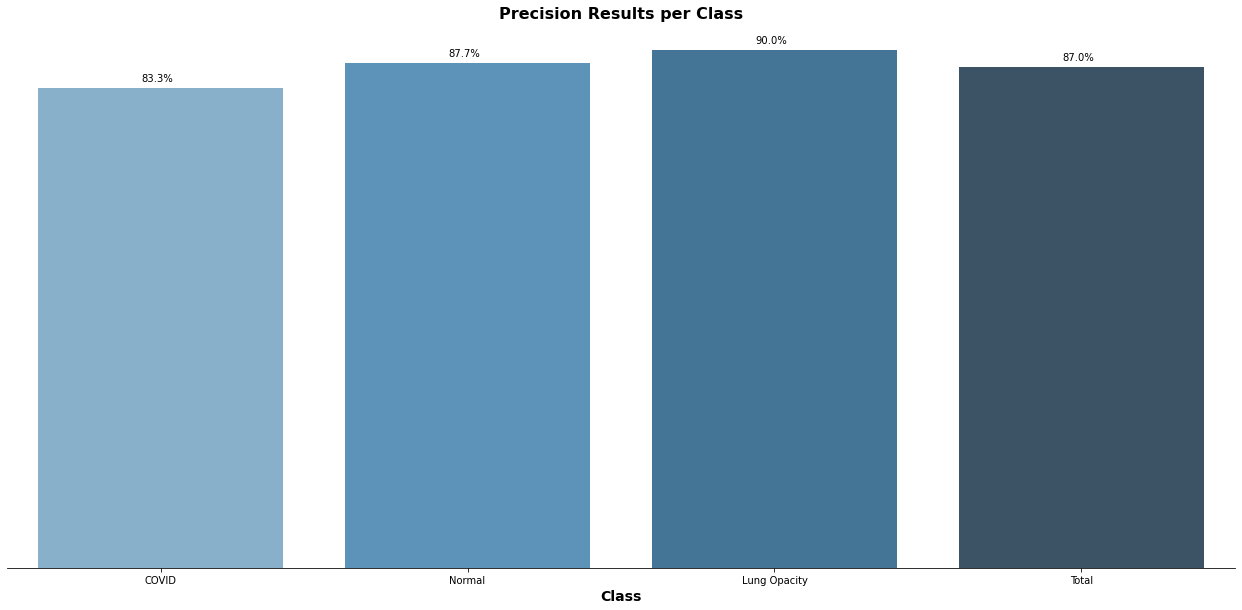

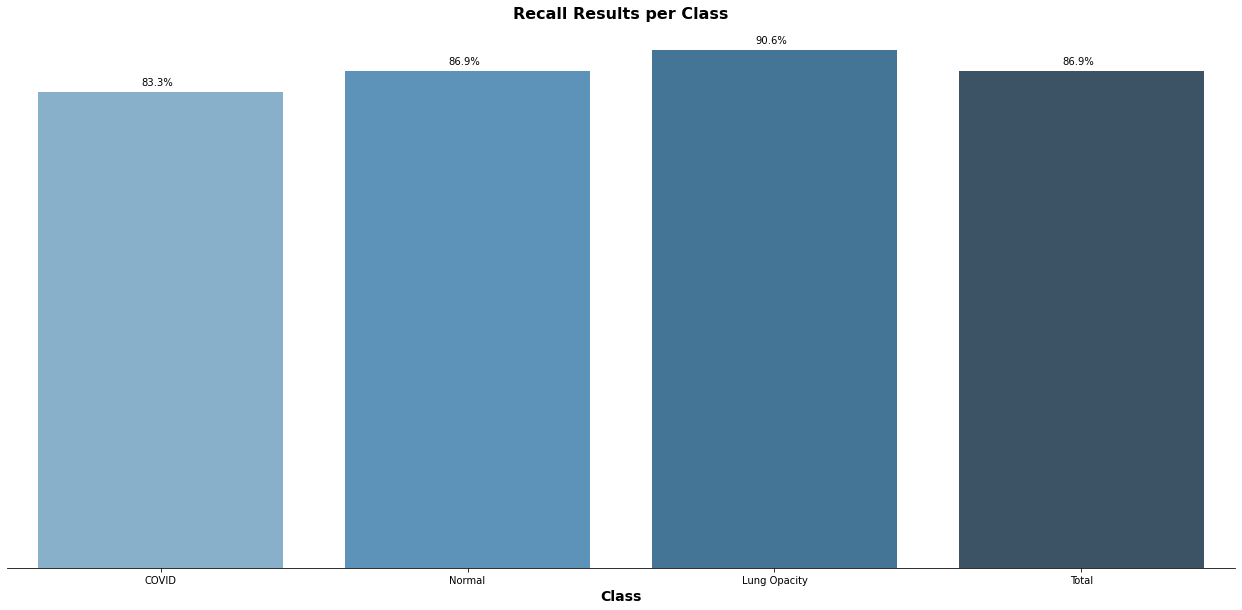

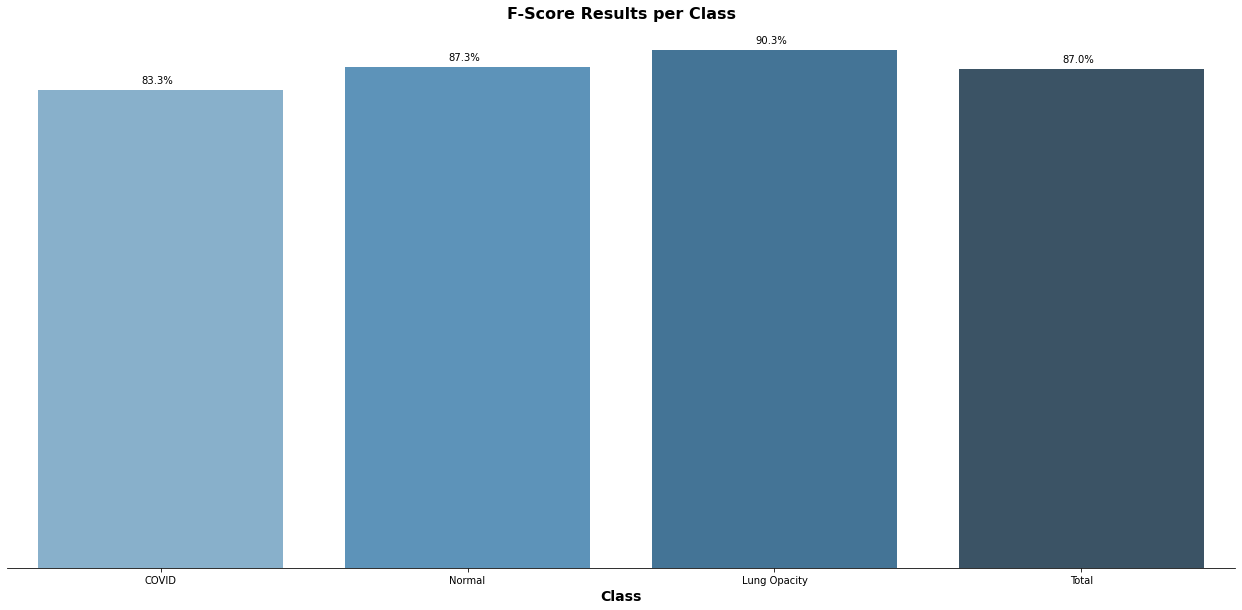

In [20]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Lung Opacity','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

<AxesSubplot:>

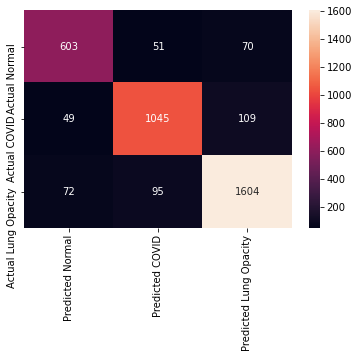

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions),index=["Actual Normal", "Actual COVID", "Actual Lung Opacity"],
columns=["Predicted Normal", "Predicted COVID","Predicted Lung Opacity"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

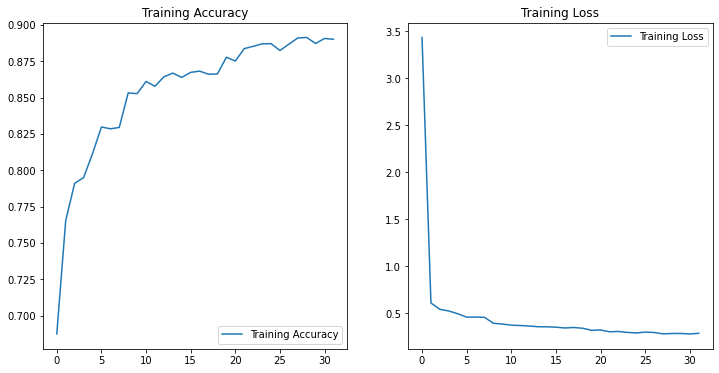

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(32)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')

plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()